In [6]:
import os 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Set up working directory - adjust this to where the repo is stored locally
%cd '/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis'

/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis


# About

__Author:__ Pat McCornack

__Date:__ December 2024

__Description:__  
This notebook preprocesses the data and does basic qc checks. This includes subsetting the variables, renaming the variables to a standard format, and taking the action specified in the finding summary. 

__Findings Summary:__  
Around 9% of observations are missing for rain/fog, with fewer missing for solar radiation. These were dropped. A single observation had a wind direction value greater than 360, this was dropped. 

__Outputs:__  
Cleaned data is output to `./data/02_clean/upem-clean-2005-2010.csv`. 

In [7]:
def agg_time(df):
    """
    Create datetime stamp using separate Month, Day, Hour, Miunute columns. 

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame to create datetime column for. 

    Returns
    -------
    pandas.DataFrame
        Dataframe with the new 'time (PST)' column, sorted by the 'time (PST)' column. 

    """
    times = []
    for index, row in df.iterrows():
        times.append(f"{str(row['Year']).split('.')[0]}-{str(row['Month']).split('.')[0]}-{str(row['Day']).split('.')[0]} {str(row['Hour']).split('.')[0]}:{str(row['Minute']).split('.')[0]}:00")

    df['time (PST)'] = pd.to_datetime(times)
    df = df.sort_values(by='time (PST)', ascending=True)

    return df

def subset_summer(df):
    """
    Subset data to summer months (May-Sept). This is done because summer is the ecologically relevant period for fog. 

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to subset.
    
    Returns
    -------
    pandas.DataFrame
        Dataframe subset to May 01 - September 30. 
    """
    df.set_index('time (PST)', inplace=True)
    df = df[df.index.month.isin([5,6,7,8,9])]
    df.reset_index(inplace=True)

    return df

## Data QC 

In [8]:
# Specify parameters
# Options
process_time = True  # Does the data have a 'time (PST)' column already, or separate columns for 'month', 'day', etc. 
summer_subset = False  # Subset to the summer months?

In [9]:
#### Specify Arguments ###
# Source data paths
src_dir = './data/01-raw/met-station/still-lab/'
src_fname = 'sci-upem-2005-2010.csv'
src_fpath = os.path.join(src_dir, src_fname)

# Out paths
outdir = './data/02_clean/'
out_fname = 'upem-clean-2005-2010.csv'
out_fname_summer = 'upem-summer-clean-2005-2010.csv'

# Define variables
var_dict = {
    'time (PST)' : 'time (PST)',
    'fog' :'Fog_Vol_mL',
    'air temperature (C)' : 'AirTC_Avg',
    'relative humidity (%)' : 'RH_Avg',
    'wind speed (m/s)' : 'WS_ms_Avg',
    'wind gust (m/s)' : 'WS_ms_Max',
    'wind direction (deg)' : 'WS_ms_WVc(2)',  # Not certain this is wind dir - see distribution
    'rain (mm)' : 'Rain_Converted_mm',  # Unsure about units
    'solar radiation (kwm2)' :'SlrkW_Avg'
}

# Fog tip value
fog_tip_v = 3.7253

# Options
process_time = True
summer_subset = False

In [10]:
#### Read in and prepare data ####
df = pd.read_csv(src_fpath)

# Create single datetime column
df = agg_time(df)

# Subset and rename columns
df = df[list(var_dict.values())]
df.columns = list(var_dict.keys())

# Create fog tip var
df['fog tips'] = df['fog'] / fog_tip_v
    
# Subset to summer months
if summer_subset == True:
    df = subset_summer(df)

df.head(3)

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),solar radiation (kwm2),fog tips
53189,2005-09-15 15:15:00,NaN,15.98,74.25,2.309,3.180,240.6,NaN,NaN,NaN
53190,2005-09-15 15:30:00,NaN,15.55,75.94,2.649,3.481,245.7,NaN,NaN,NaN
53191,2005-09-15 15:45:00,NaN,15.27,77.03,2.896,3.490,249.4,NaN,NaN,NaN


### Missing Values
Observations:
1. Around 12k fog and rain observations are missing, fewer are missing for solar radiation. 
3. A small number of solar radiation observations are missing. 
4. The observations span a short period of time - 4 months from 09-2005 to 01-2006.

Actions:
1. Drop all missing observations.

Notes: 
- Dropping all fog observations also dropped other missing observations. 


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137674 entries, 53189 to 137673
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   time (PST)              137674 non-null  datetime64[ns]
 1   fog                     125186 non-null  float64       
 2   air temperature (C)     137674 non-null  float64       
 3   relative humidity (%)   137674 non-null  float64       
 4   wind speed (m/s)        137674 non-null  float64       
 5   wind gust (m/s)         137674 non-null  float64       
 6   wind direction (deg)    137674 non-null  float64       
 7   rain (mm)               125186 non-null  float64       
 8   solar radiation (kwm2)  132118 non-null  float64       
 9   fog tips                125186 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 11.6 MB


In [12]:
# When are values missing? 
missing = df.loc[df.isna().any(axis=1)]
pd.to_datetime(missing['time (PST)']).describe()

count                            12488
mean     2005-11-23 10:48:17.469570816
min                2005-09-15 15:15:00
25%                2005-10-18 03:41:15
50%                2005-11-26 11:37:30
75%                2005-12-29 00:03:45
max                2006-01-30 12:30:00
Name: time (PST), dtype: object

In [13]:
df.dropna(subset='fog', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125186 entries, 2835 to 137673
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   time (PST)              125186 non-null  datetime64[ns]
 1   fog                     125186 non-null  float64       
 2   air temperature (C)     125186 non-null  float64       
 3   relative humidity (%)   125186 non-null  float64       
 4   wind speed (m/s)        125186 non-null  float64       
 5   wind gust (m/s)         125186 non-null  float64       
 6   wind direction (deg)    125186 non-null  float64       
 7   rain (mm)               125186 non-null  float64       
 8   solar radiation (kwm2)  125186 non-null  float64       
 9   fog tips                125186 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 10.5 MB


### Univariate Distributions

Check boxplots of each variable to assess data quality.

Observations:
1. Relative humidity is typically high at the site. 
2. Wind typically comes from the northwest, but has a higher spread than pozo.  
3. Most fog observations are 0 - this skews the distribution.
4. There's a wind direction value of over 360

Actions
1. Remove the observation where wind direction > 360

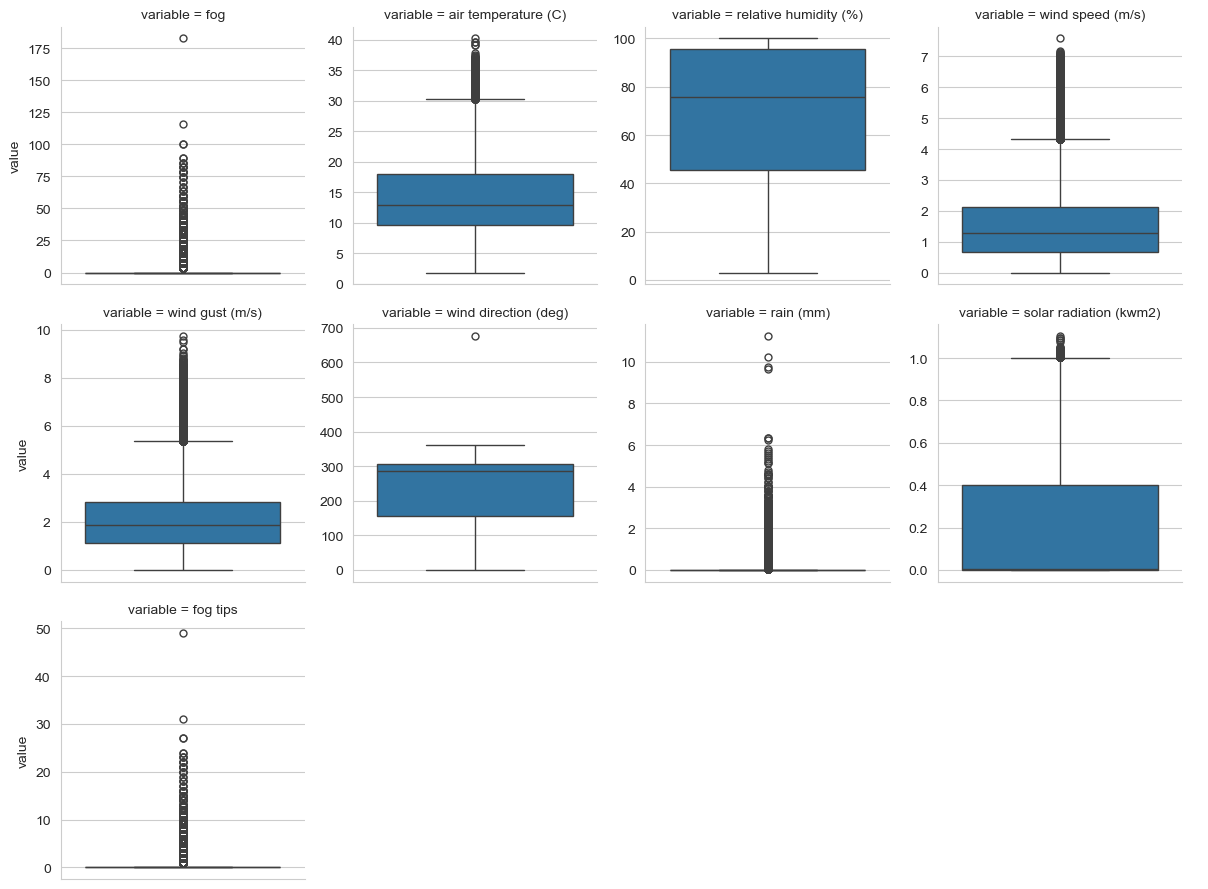

In [14]:
#### Quick plot of distributions ####
# Create long form data
value_col = df.columns.drop(['time (PST)']).tolist()
df_long = pd.melt(df, id_vars=['time (PST)'], value_vars=value_col)

# Plot boxplots
sns.catplot(data=df_long, kind='box', col='variable', y='value',
            sharey=False, height=3, col_wrap=4)
plt.show()


In [15]:
#### Check the actual values ####
df.describe()

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),solar radiation (kwm2),fog tips
count,125186,125186.000000,125186.000000,125186.000000,125186.000000,125186.000000,125186.000000,125186.000000,125186.000000,125186.000000
mean,2008-03-06 12:31:02.108382976,0.487341,14.121991,68.259854,1.542205,2.136042,239.288857,0.015100,0.209880,0.130819
min,2006-01-30 13:00:00,0.000000,1.847000,3.014000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2007-01-16 18:33:45,0.000000,9.652500,45.530000,0.677000,1.134000,155.000000,0.000000,0.000000,0.000000
50%,2008-05-07 11:37:30,0.000000,12.830000,75.570000,1.294000,1.872000,285.600000,0.000000,0.006000,0.000000
75%,2009-03-29 11:41:15,0.000000,17.920000,95.800000,2.139000,2.834000,305.100000,0.000000,0.401000,0.000000
max,2010-02-18 11:45:00,182.540000,40.180000,100.000000,7.583000,9.750000,677.000000,11.245000,1.105000,49.000081
std,NaN,3.002636,5.779619,28.692206,1.129139,1.328249,93.697301,0.160924,0.299534,0.806012


### Remove wind direction outlier

In [16]:
ind = df.loc[df['wind direction (deg)'] > 360].index
df.drop(ind, axis=0, inplace=True)
df['wind direction (deg)'].describe()

count    125185.000000
mean        239.285361
std          93.689508
min           0.000000
25%         155.000000
50%         285.600000
75%         305.100000
max         360.000000
Name: wind direction (deg), dtype: float64

### Fog Check
Given the focus of further analysis on fog at the site, further check the distribution of fog.

Note that prior knowledge indicates there's bycatch of rain in the winter, which inflates some of the fog measurements. Further analyses typically focus on summer data as that is the most ecologically relevant time period, which negates this issue. 

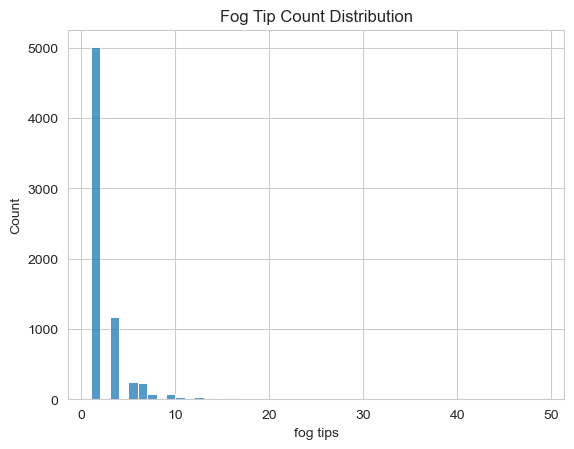

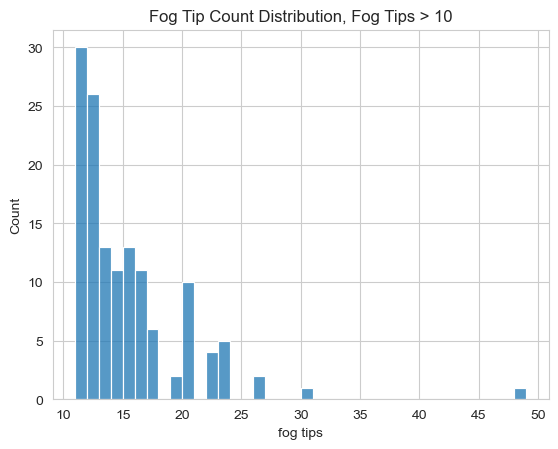

In [17]:
#### Check Distribution of Fog Values ####
sns.histplot(df['fog tips'].loc[df['fog tips']>0],
             binwidth=1)
plt.title('Fog Tip Count Distribution')
plt.show()

# Check right tail of distribution
sns.histplot(df['fog tips'].loc[df['fog tips']>10],
             binwidth=1)
plt.title('Fog Tip Count Distribution, Fog Tips > 10')
plt.show()

### Save out cleaned data

In [18]:
#### Save out cleaned data ####
if summer_subset == True:
    out_fpath = os.path.join(outdir, out_fname_summer)
    #df.to_csv(out_fpath)

else:
    out_fpath = os.path.join(outdir, out_fname)
   # df.to_csv(out_fpath)

print(out_fpath)

./data/02_clean/upem-clean-2005-2010.csv
